In [170]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# notebook全部内容输出
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt 

In [171]:
credits= pd.read_csv('credits.csv')
#keywords= pd.read_csv('keywords.csv')
#links_small= pd.read_csv('links_small.csv')
#links= pd.read_csv('links.csv')
movies= pd.read_csv('movies_metadata.csv' )
ratings_small= pd.read_csv('ratings_small.csv')
ratings= pd.read_csv('ratings.csv')

In [172]:
#process data(remove missing data, join movies with their respective ratings)
movies.dropna(thresh= 20, inplace= True)
ratings.groupby('movieId')['rating'].mean()
movies_rating= pd.DataFrame(ratings.groupby('movieId')['rating'].mean())
movies_rating['rating']= movies_rating['rating'].astype('float64')
movies_rating= movies_rating.reset_index() 
movies_rating['movieId']= movies_rating['movieId'].astype('int')
movies['id']= movies['id'].astype('int')
movies.revenue= movies.revenue.astype('int')
movies.budget= movies.budget.astype('int') 
#create a new measure ROI
movies['ROI(%)']= (movies.revenue- movies.budget)/ movies.budget * 100 
#create a new measure profitability
movies['Profitability']= movies.revenue- movies.budget
movies['Profitability']= movies['Profitability'].astype('float64') 
movies= movies_rating.merge(movies, left_on= 'movieId', right_on='id')
movies.isnull().sum()/len(movies) *100
movies.drop(['belongs_to_collection','homepage','tagline'], axis= 1, inplace= True)

movieId
1        3.89
2        3.24
3        3.18
4        2.88
5        3.08
         ... 
176267   4.00
176269   3.50
176271   5.00
176273   1.00
176275   3.00
Name: rating, Length: 45115, dtype: float64

movieId                  0.00
rating                   0.00
adult                    0.00
belongs_to_collection   87.45
budget                   0.00
genres                   0.00
homepage                82.73
id                       0.00
imdb_id                  0.03
original_language        0.01
original_title           0.00
overview                 1.39
popularity               0.00
poster_path              0.20
production_companies     0.00
production_countries     0.00
release_date             0.05
revenue                  0.00
runtime                  0.01
spoken_languages         0.00
status                   0.11
tagline                 48.48
title                    0.00
video                    0.00
vote_average             0.00
vote_count               0.00
ROI(%)                  67.03
Profitability            0.00
dtype: float64

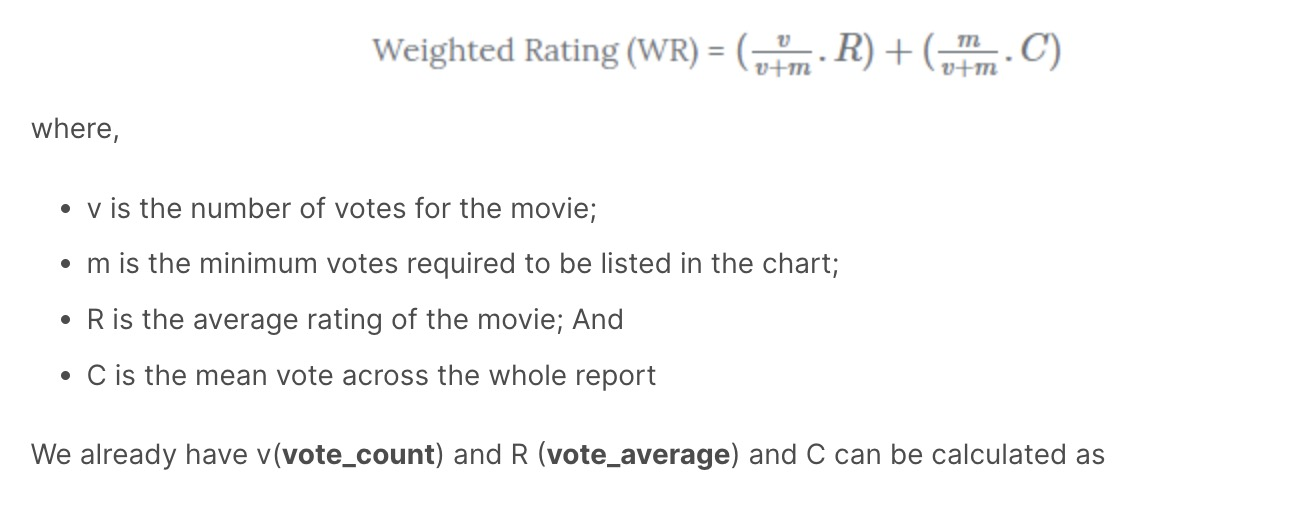

In [173]:
# weight ratings based on ratings count
C= movies.rating.mean()
m= movies['rating'].quantile(0.90)   #cote counts exceed 95% of total movies
df1= pd.DataFrame(ratings.groupby('movieId')['userId'].count()).reset_index()
df2 = movies.merge(df1)
df2= df2.rename({'userId':'rating_count'}, axis= 1)
movies= df2.copy()
def weighted_rating(x, m=m, C=C):
    v = x['rating_count']
    R = x['rating']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)
# Define a new feature 'score' and calculate its value with `weighted_rating()
movies['weighted_rating']= movies.apply(weighted_rating, axis= 1)

In [174]:
from ast import literal_eval
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies= movies.merge(credits, left_on= 'movieId', right_on= 'id')
movies['cast'] = movies['cast'].apply(literal_eval)
movies['crew'] = movies['crew'].apply(literal_eval)
movies['production_companies'] = movies['production_companies'].apply(literal_eval)
movies['production_countries'] = movies['production_countries'].apply(literal_eval)
movies['spoken_languages'] = movies['spoken_languages'].apply(literal_eval)
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan
movies['cast']= movies['cast'].fillna('[]').apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies['production_companies']= movies['production_companies'].fillna('[]').apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies['production_countries']= movies['production_countries'].fillna('[]').apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies['spoken_languages']= movies['spoken_languages'].fillna('[]').apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies['Director']= movies.crew.apply(get_director)
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
movies.drop(['rating','poster_path', 'crew','id_x','imdb_id','original_title','overview','release_date','id_y'],axis= 1, inplace= True)
list_genres= []
for i in range(len(movies)):
    for j in list(movies.genres)[i]:
        list_genres.append(j)
data= {'Type_movies': list_genres, 'col':[* range(len(list_genres))]}
df3= pd.DataFrame(data= data)
df3= pd.DataFrame(df3.groupby('Type_movies')['col'].count()).reset_index()
def get_first(x):
    for first in x:
        return x[0]  
    return np.nan
movies['cast']= movies['cast'].apply(get_first)
movies.genres = movies.genres.apply(get_first)
movies.production_companies = movies.production_companies.apply(get_first)
movies.production_countries = movies.production_countries.apply(get_first)

In [175]:
df_count= movies[['year','genres','movieId']].groupby(['year','genres']).count().reset_index()
df_count= df_count.drop(index= 1223)

In [176]:
df_count

,year,genres,movieId
0,1890,Documentary,1
1,1891,Action,1
2,1891,Documentary,1
3,1894,Documentary,3
4,1895,Documentary,2
...,...,...,...
1218,2016,Action,3
1219,2016,Drama,1
1220,2016,Family,1
1221,2016,Horror,1


In [177]:
df_count.year.unique()

array(['1890', '1891', '1894', '1895', '1896', '1900', '1902', '1903',
       '1904', '1905', '1906', '1910', '1912', '1913', '1914', '1915',
       '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923',
       '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931',
       '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939',
       '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947',
       '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955',
       '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963',
       '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971',
       '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
       '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
      

In [178]:
df_count['year']= df_count['year'].astype('object')
df_count['movieId']= df_count['movieId'].astype('object')

In [179]:
df_count.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1223 entries, 0 to 1222
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     1223 non-null   object
 1   genres   1223 non-null   object
 2   movieId  1223 non-null   object
dtypes: object(3)
memory usage: 38.2+ KB


In [180]:
df_count

,year,genres,movieId
0,1890,Documentary,1
1,1891,Action,1
2,1891,Documentary,1
3,1894,Documentary,3
4,1895,Documentary,2
...,...,...,...
1218,2016,Action,3
1219,2016,Drama,1
1220,2016,Family,1
1221,2016,Horror,1


In [181]:
years= []
for year in df_count.year.unique():
    years.append(year)
years    

['1890',
 '1891',
 '1894',
 '1895',
 '1896',
 '1900',
 '1902',
 '1903',
 '1904',
 '1905',
 '1906',
 '1910',
 '1912',
 '1913',
 '1914',
 '1915',
 '1916',
 '1917',
 '1918',
 '1919',
 '1920',
 '1921',
 '1922',
 '1923',
 '1924',
 '1925',
 '1926',
 '1927',
 '1928',
 '1929',
 '1930',
 '1931',
 '1932',
 '1933',
 '1934',
 '1935',
 '1936',
 '1937',
 '1938',
 '1939',
 '1940',
 '1941',
 '1942',
 '1943',
 '1944',
 '1945',
 '1946',
 '1947',
 '1948',
 '1949',
 '1950',
 '1951',
 '1952',
 '1953',
 '1954',
 '1955',
 '1956',
 '1957',
 '1958',
 '1959',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 

In [182]:
df_count.genres

0       Documentary
1            Action
2       Documentary
3       Documentary
4       Documentary
           ...     
1218         Action
1219          Drama
1220         Family
1221         Horror
1222         Action
Name: genres, Length: 1223, dtype: object

In [183]:
genres= df_count['genres'].unique().tolist()
for genre in genres:
    if 
count= []

SyntaxError: invalid syntax (<ipython-input-183-9deb1e47339a>, line 3)

In [ ]:
df_count.groupby('year')['genres'].count()

In [ ]:
movies.groupby('Director')['weighted_rating'].mean().nlargest()

In [ ]:
movies_1= movies[(movies['budget'] != 0) & (movies['revenue'] != 0)]

In [ ]:
cut_off= movies.weighted_rating.quantile(0.80)

In [ ]:
cut_off

In [ ]:
list_result= []
for num in movies.weighted_rating.values: 
    if num > cut_off:
        list_result.append(1)
    else:
        list_result.append(0) 
movies_1['result']= pd.DataFrame(list_result) 
for i in ('genres','production_companies','production_countries','cast'):
    movies_1[i]= movies_1[i].fillna('NaN') 
df_year= pd.DataFrame(movies_1.groupby('year')['movieId'].nunique())
df_year.reset_index(inplace= True)
df_year.rename(columns= {'movieId':'#movies_released'}, inplace= True)
df_year.year= df_year.year.astype('int') 
movies_1.year= movies_1.year.astype('int')
movies_1= pd.merge(df_year,movies_1, on= 'year' )
# movies_1.drop('movieId', axis= 1, inplace= True)
movies_1.drop(['adult','video'], axis= 1, inplace= True)

In [ ]:
movies_1['popularity'] = movies_1['popularity'].astype('float64')

There are 2 good movies (weighted rating > cut-off 3.54, greater than 80% of all movies) in Top 10 Popular Movies  

In [ ]:
pop= movies_1.sort_values('popularity', ascending=False)
dummy =  pop.result.tolist()

bar_colors = []
for value in dummy:
    if value == 1:
        bar_colors.append('green')
    else:
        
        bar_colors.append('skyblue')
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(10),pop['popularity'].head(10), align='center',
        color= bar_colors)
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Top 10 Popular Movies")

In [ ]:
pop.result.mean()
pop.head(10).result.mean()

In [ ]:
revenue= movies_1.sort_values('revenue', ascending=False)
dummy =  revenue.result.tolist()

bar_colors = []
for value in dummy:
    if value == 1:
        bar_colors.append('green')
    else:
        bar_colors.append('skyblue')
plt.figure(figsize=(12,4))
plt.barh(revenue['title'].head(10),revenue['revenue'].head(10), align='center',
        color= bar_colors)
plt.gca().invert_yaxis()
plt.xlabel("Revenue ($Billion)")
plt.title("Top Revenue Movies")

In [ ]:
#drop outliners
movies_1.drop(index= [14, 322], inplace= True)

There are 4 good movies out of top 10 profitable movies(40%), greater than average 27.8%  

In [ ]:
profit.result.mean()
profit.head(10).result.mean()

In [ ]:
profit= movies_1.sort_values('Profitability', ascending=False)
dummy =  profit.result.tolist()

bar_colors = []
for value in dummy:
    if value == 1:
        bar_colors.append('green')
    else:
        bar_colors.append('skyblue')
plt.figure(figsize=(12,4))
plt.barh(profit['title'].head(10),profit['Profitability'].head(10), align='center',
        color= bar_colors)
plt.gca().invert_yaxis()
plt.xlabel("Revenue ($Billion)")
plt.title("Top Profitable Movies")

In [ ]:
roi= movies_1.sort_values('ROI(%)', ascending=False)
dummy =  roi.result.tolist()

bar_colors = []
for value in dummy:
    if value == 1:
        bar_colors.append('green')
    else:
        bar_colors.append('skyblue')
        
plt.figure(figsize=(12,4))
plt.barh(roi['title'].head(10),roi['ROI(%)'].head(10), align='center',
        color= bar_colors[:10] )
plt.gca().invert_yaxis()
plt.xlabel("ROI (%)")
plt.title("Top ROI Movies")

In [ ]:
movies_1.columns

In [ ]:
movies_1.groupby('genres')['popularity'].mean().nlargest()

In [ ]:
roi.groupby('genres')['ROI(%)'].mean().nlargest()

In [ ]:
roi.columns

In [ ]:
roi.groupby('genres')['Profitability'].mean().nlargest()

In [ ]:
np.set_printoptions(suppress=True) #np中不显示科学计数法
pd.set_option('display.float_format', lambda x: '%.2f' %x) 

In [ ]:
movies_1.groupby('production_companies')['movieId'].nunique().nlargest()

In [ ]:
movies_1.groupby('production_companies')['weighted_rating'].mean().nlargest()

In [ ]:
movies_1[movies_1['Director']== 'Dean Parisot']

In [ ]:
roi.groupby('Director')['weighted_rating'].mean().nlargest(10)

In [ ]:
movies_1.groupby('genres')['ROI(%)'].mean().nlargest()

In [ ]:
movies_1.groupby('year')['genres'].nunique()

In [ ]:
movies_1[['year','genres','movieId']].groupby(['year','genres']).nunique()

In [ ]:
plt.stackplot(movies_1[['year','genres','movieId']].groupby(['year','genres']).nunique().reset_index()['year'],movies_1[['year','genres','movieId']].groupby(['year','genres']).nunique().reset_index()['movieId'])
#     plt.xticks(years)
#     plt.xlim(years.iloc[0],years.iloc[-1])
#     plt.ylim(0,1)
# plt.legend()

In [ ]:
#movies_1.to_excel('movies_cleaned.xlsx', index=False)

In [ ]:
np.set_printoptions(suppress=True) #np中不显示科学计数法
pd.set_option('display.float_format', lambda x: '%.2f' %x) #pd中不显示科学计数法

In [ ]:
movies_1.to_csv("movies_cleaned.csv", index=False)

In [ ]:
np.set_printoptions(suppress=True) #np中不显示科学计数法
pd.set_option('display.float_format', lambda x: '%.0f' %x) #pd中不显示科学计数法

In [ ]:
movies_1.groupby('genres')['budget'].mean().nlargest()

In [ ]:
movies_1.groupby('Director')['weighted_rating'].mean().sort_values(ascending= False).nlargest(10)

In [ ]:
movies_1.groupby('cast')['weighted_rating'].mean().sort_values(ascending= False).nlargest(10)

In [ ]:
movies_1.groupby('genres')['weighted_rating'].mean().sort_values(ascending= False)

In [ ]:
movies_1.groupby('cast')['weighted_rating'].mean().sort_values(ascending= False).head(10)

In [ ]:
movies_1.groupby('Director')['weighted_rating'].mean().sort_values(ascending= False).head()

In [ ]:
movies_1.groupby('production_countries')['weighted_rating'].mean().sort_values(ascending= False).head()

In [ ]:
movies_1[movies_1['result']== 1]

In [ ]:
movies_1.isnull().sum()

In [184]:
movies_1.groupby('genres')['revenue'].mean().nlargest()

genres
Adventure   288384929.87
Family      275806784.90
Animation   257553415.97
Fantasy     171223286.91
History     167415100.40
Name: revenue, dtype: float64

In [186]:
movies_1.columns

Index(['year', '#movies_released', 'movieId', 'budget', 'genres',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'revenue', 'runtime', 'spoken_languages',
       'status', 'title', 'vote_average', 'vote_count', 'ROI(%)',
       'Profitability', 'rating_count', 'weighted_rating', 'cast', 'Director',
       'result'],
      dtype='object')

In [211]:
lan_df= pd.DataFrame(movies_1.groupby('original_language')['movieId'].nunique().reset_index().sort_values(by= 'movieId', ascending= False))
lan_df

,original_language,movieId
5,en,1444
8,fr,26
6,es,16
18,ru,12
12,ja,11
3,de,9
13,ko,9
11,it,9
10,hi,7
24,zh,5


,original_language
en,1447
fr,26
es,16
ru,12
ja,11
de,9
ko,9
it,9
hi,7
zh,5


([<matplotlib.patches.Wedge at 0x7f8f844def40>,
 [Text(-1.0643416704827826, 0.27780714258981865, 'English'),
  Text(1.2578583147888063, -0.3283176204785006, 'Other')],
 [Text(-0.5805500020815177, 0.15153116868535563, '91.9%'),
  Text(0.7740666552546499, -0.20204161260215422, '8.1%')])

Text(0.5, 1.0, 'Movies Count by English Language vs Other')

(-1.1171705963010967,
 1.3035493904857836,
 -1.1029116973126851,
 1.107697067129908)

([<matplotlib.patches.Wedge at 0x7f8f8207ce20>,
 [Text(0.8835282846287095, 0.6552692349416768, 'French'),
  Text(-0.10781885436251673, 1.0947031993394167, 'Spanish'),
  Text(-0.7778174593052023, 0.7778174593052024, 'Russian'),
  Text(-1.0732723430423814, 0.24101136417255703, 'Japanese'),
  Text(-1.060153672374984, -0.2933840332223881, 'German'),
  Text(-0.8329297311571333, -0.7184901272491543, 'Korean'),
  Text(-0.44576544540548946, -1.0056307312738837, 'Italian'),
  Text(-0.02699535137520363, -1.0996687005658248, 'Hindi'),
  Text(0.29338403322238804, -1.060153672374984, 'Chinese'),
  Text(0.5185364105085973, -0.9701133907831906, 'Danish'),
  Text(0.9701133907831905, -0.5185364105085978, 'Others')],
 [Text(0.642566025184516, 0.4765594435939467, '20.3%'),
  Text(-0.07841371226364853, 0.7961477813377575, '12.5%'),
  Text(-0.565685424949238, 0.5656854249492381, '9.4%'),
  Text(-0.7805617040308228, 0.17528099212549603, '8.6%'),
  Text(-0.771020852636352, -0.21337020597991863, '7.0%'),
  Te

Text(0.5, 1.0, 'Movies Count by Other Languages')

(-1.103378820828069,
 1.100160896229908,
 -1.1015631918070925,
 1.1085142868169597)

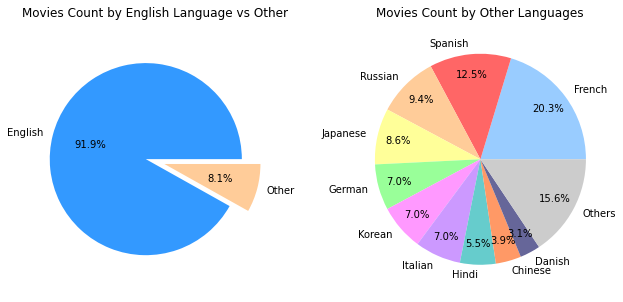

In [291]:
import matplotlib.pyplot as plt
movies_pie= movies_1.copy()
lang_df= pd.DataFrame(movies_pie['original_language'].value_counts())
lang_df

# First pie chart
values1 = [1447, 128]
labels1 = ['English', 'Other']
explode1 = [0, 0.2]  # Explode the "Other" category

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(values1, labels=labels1, explode=explode1, autopct='%1.1f%%', colors=['#3399FF', '#FFCC99'])
ax1.set_title('Movies Count by English Language vs Other')
ax1.axis('equal')

# Second pie chart
values2 = lang_df.drop(index='en').iloc[:10, 0].values.tolist()+[20]
labels2 = ['French', 'Spanish', 'Russian', 'Japanese', 'German', 'Korean', 'Italian', 'Hindi', 'Chinese', 'Danish', 'Others']

ax2.pie(values2, pctdistance=0.8, labels=labels2, autopct='%1.1f%%', colors=['#99CCFF', '#FF6666', '#FFCC99', '#FFFF99', '#99FF99', '#FF99FF', '#CC99FF', '#66CCCC', '#FF9966', '#666699', '#CCCCCC'])
ax2.set_title('Movies Count by Other Languages')
ax2.axis('equal')

plt.subplots_adjust(wspace=0.4)

plt.show()


In [300]:
20/24

0.8333333333333334

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of Movies')

Text(0.5, 1.0, 'Number of Movies Released Each Year by Result')

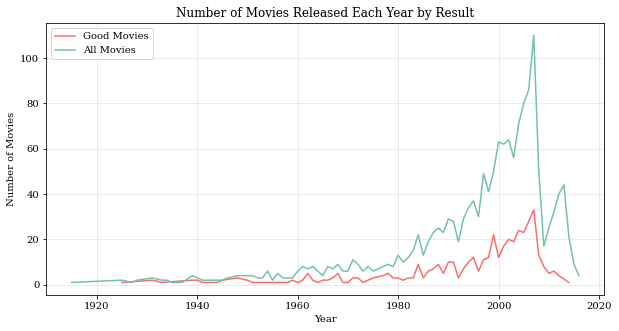

In [299]:
import matplotlib.pyplot as plt

# Data
result_1 = movies_1[movies_1['result']== 1].groupby('year')['movieId'].count()
result_all = movies_1.groupby('year')['movieId'].count()

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(result_1, color='#FF6B6B', label='Good Movies')
ax.plot(result_all, color='#70C1B3', label='All Movies')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Movies')
ax.set_title('Number of Movies Released Each Year by Result')
ax.legend()

# Adding Grid
ax.grid(alpha=0.3)

plt.show()


Text(0.5, 1.0, 'Movie Count by Year')

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Movie Count')

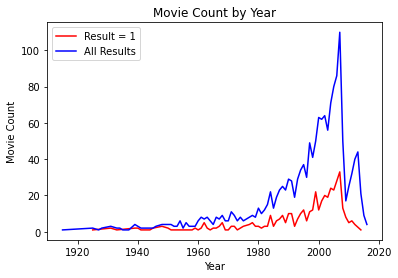

In [296]:
import matplotlib.pyplot as plt

# Plot both lines
plt.plot(movies_1[movies_1['result'] == 1].groupby('year')['movieId'].count(), color='red', label='Result = 1')
plt.plot(movies_1.groupby('year')['movieId'].count(), color='blue', label='All Results')

# Set title, x-label, and y-label
plt.title('Movie Count by Year')
plt.xlabel('Year')
plt.ylabel('Movie Count')

# Add legend and display plot
plt.legend()
plt.show()


<AxesSubplot:xlabel='year'>

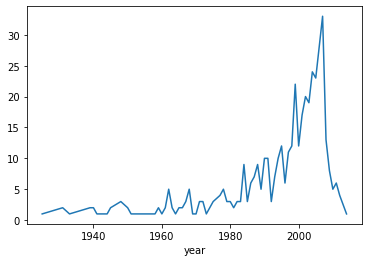

In [295]:

movies_1[movies_1['result']== 1].groupby('year')['movieId'].count().plot()
movies_1.groupby('year')['movieId'].count().plot()

<AxesSubplot:xlabel='year'>

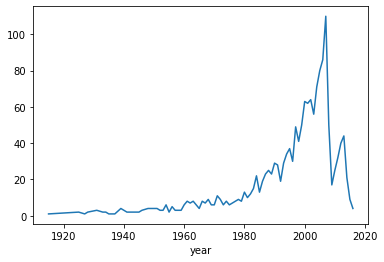

In [294]:
movies_1.groupby('year')['movieId'].count().plot()

In [ ]:
kw= pd.read_csv('keywords.csv')
movies_1['weighted_rating'].quantile(0.85)
movies_2= movies_1[movies_1['weighted_rating']> 3.7 ].merge(kw, left_on= 'movieId', right_on= 'id')
movies_2['keywords']= movies_2['keywords'].apply(literal_eval).fillna('[]').apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else []) 
movies_2['keywords_1']= movies_2['keywords'].apply(get_first)
def get_second(x):
    for second in x:
        if len(x) >=2:
            return x[1]  
    return np.nan
movies_2['keywords_2']= movies_2['keywords'].apply(get_second)
data= {'kw': movies_2['keywords_1'].tolist()+ (movies_2['keywords_2'].tolist()), 
       'cnt': [*range(len(movies_2['keywords_1'].tolist()+ (movies_2['keywords_2'].tolist())))] } 
df2= pd.DataFrame(data= data)
df2.dropna(inplace= True)
text = movies_2['keywords_1'].tolist()+ movies_2['keywords_2'].tolist() 
# Create a list of strings as input

text = ['world war i', 'fire',
 'philadelphia',
 'corruption',
 'monte carlo',
 'germany',
 'detective',
 'texas',
 'mexico',
 "new year's eve",
 'musical',
 'southern usa',
 'brother brother relationship',
 'assassination',
 'roman',
 'israel',
 'mutiny',
 'independent film',
 'usa',
 'cairo',
 'blindness and impaired vision',
 'usa president',
 'love triangle',
 'sheriff',
 'ambush',
 'prison',
 'usa',
 'moon',
 'san francisco',
 'female nudity',
 'london england',
 'england',
 'life and death',
 'paris',
 'farewell',
 'prison',
 'netherlands',
 'stewardess',
 'based on novel',
 'elves',
 'helicopter',
 'female nudity',
 'guerrilla',
 'exploitation',
 'taxi',
 'video game',
 'prison',
 'uss enterprise',
 'miami',
 'street gang',
 'dancing',
 'prophecy',
 'holiday',
 'dancing',
 'new york',
 'buddhism',
 'brother brother relationship',
 'swashbuckler',
 'helicopter',
 'minister',
 'cia',
 'therapist',
 'dystopia',
 'gang',
 'holiday',
 'beach',
 'underdog',
 'prison',
 'skab under tv',
 'new york',
 'crime fighter',
 'violence',
 'wish',
 'cyborg',
 'film business',
 'suicide attempt',
 'surfer',
 'sex',
 'riddle',
 'brother brother relationship',
 'holiday',
 'rookie cop',
 'father son relationship',
 'father son relationship',
 'newspaper',
 'new orleans',
 'new york',
 'detective',
 'paris',
 'dual identity',
 'loss of mother',
 'roommate',
 'japan',
 'clone',
 'robbery',
 'exotic island',
 'bomb',
 'brother brother relationship',
 'gambling',
 'board game',
 'federation',
 'new york',
 'spacecraft',
 'paris',
 'sport',
 'divorce',
 'london england',
 'paris',
 'pornography',
 'brother brother relationship',
 'drag queen',
 'karaoke',
 'usa',
 'secret',
 'lapd',
 'shakespeare',
 'paris',
 'usa president',
 'farewell',
 'southern usa',
 'child abuse',
 'martinique',
 'space battle',
 'artificial intelligence',
 'venice',
 'cataclysm',
 'london england',
 'video game',
 'san francisco',
 'small town',
 'monster',
 'teenager',
 'shark attack',
 'new york',
 'individual',
 'terror',
 'usa',
 'mars',
 'bounty',
 'drug dealer',
 'martial arts',
 'love triangle',
 'prison',
 'paris',
 'duke',
 'southern usa',
 'son',
 'workaholic',
 'california',
 'dancing',
 'servant',
 'elves',
 'london england',
 'saving the world',
 'new york',
 'paris',
 'suicide',
 'resistance',
 'submarine',
 'based on tv series',
 'saving the world',
 'london england',
 'gay',
 'london england',
 'sushi restaurant',
 'paris',
 'california',
 'loss of lover',
 'amnesia',
 'miami',
 'paris',
 'shotgun',
 'white russian',
 'christianity',
 'free love',
 'skab under tv',
 'refugee',
 'brother brother relationship',
 'amnesia',
 'aristotle',
 'brother brother relationship',
 'father son relationship',
 'berlin',
 'paris',
 'jealousy',
 'london england',
 'competition',
 'love triangle',
 'riddle',
 'himalaya',
 'bachelor',
 'transporter',
 'lion',
 'clone',
 'loss of son',
 'salesclerk',
 'chaos theory',
 'new york',
 'witch',
 'based on tv series',
 'brain tumor',
 'snake',
 'car race',
 'mammoth',
 'philadelphia',
 'london england',
 'world war ii',
 'sex',
 'professor',
 'evisceration',
 'poison',
 'independent film',
 'male nudity',
 'world war ii',
 'usa president',
 'hunter',
 'midlife crisis',
 'winter',
 'religion and supernatural',
 'brother sister relationship',
 'saving the world',
 'saving the world',
 'new york',
 'love at first sight',
 'california',
 'parody',
 'england',
 'bureaucracy',
 'new love',
 'based on novel',
 'journalist',
 'father son relationship',
 'job-hopping',
 'sex',
 'corruption',
 '1970s',
 'robbery',
 'police',
 'competition',
 'car race',
 'fight',
 'rebel',
 'tree',
 'infidelity',
 'saving the world',
 'brother brother relationship',
 'rape',
 'self-defense',
 'monster',
 'terrorism',
 'bank',
 'conspiracy of murder',
 'competition',
 'capitalism',
 'new delhi india',
 'wife husband relationship',
 'slapstick',
 'silent film',
 'monster',
 'musical',
 'washington d.c.',
 'based on novel',
 'dictator',
 'obsession',
 'dangerous',
 'gold',
 'screenwriter',
 'universal exhibition',
 'rape',
 'chauffeur',
 'spy',
 'prince',
 'jewry',
 'climate change',
 'prison',
 'arabian',
 'education',
 'general',
 'nurse',
 'ranch',
 'sheriff',
 'rebel',
 'hong kong',
 'jupiter',
 'hotel',
 'sex',
 'suicide',
 'rape',
 'prostitute',
 'sex',
 'rock and roll',
 'stadium',
 'world war ii',
 'pilot',
 'future',
 'dwarves',
 'news broadcast',
 'nudity',
 'river',
 'biography',
 'street gang',
 'hacker',
 'convict',
 'genesis',
 'corruption',
 'billard',
 'dance',
 'witch',
 'monster',
 'dancer',
 'cat',
 'japan',
 'california',
 'evil prince',
 'journalist',
 'giant snake',
 'drag queen',
 'vampire',
 'social commentary',
 'police detective',
 'boss',
 'mission of murder',
 'love at first sight',
 'sex',
 'Øverste hylde',
 'monster',
 'cook',
 'postal worker',
 'shotgun',
 'screenplay',
 'underground',
 'undercover',
 'eroticism',
 'amnesia',
 'corruption',
 'corruption',
 'dog biscuit',
 'film producer',
 'lovesickness',
 'butler',
 'mercenary',
 'corruption',
 'undercover',
 'san francisco',
 'bank',
 'loss of sister',
 'yuppie',
 'new york',
 'dream',
 'detective',
 'treasure',
 'taxi',
 'chicago',
 'miami',
 'disappearance',
 'starfleet',
 'sex',
 'patriotism',
 'london england',
 'basketball',
 'divorced woman',
 'england',
 'london england',
 'sex',
 'loss of father',
 'voodoo',
 'marriage proposal',
 'neo-nazi',
 'atomic bomb',
 'house on fire',
 "love of one's life",
 'france',
 'nasa',
 'regret',
 'black people',
 'sense of guilt',
 'claude monet',
 'spaceship',
 'simulation',
 'italy',
 'airplane',
 "new year's eve",
 'hacker',
 'bachelor',
 'self-discovery',
 'weapon',
 'attic',
 'shark',
 'travel',
 'dancing',
 'spain',
 'war on drugs',
 'spacecraft',
 'gangster boss',
 'greenhouse',
 'female friendship',
 'rabbi',
 'pickpocket',
 'love triangle',
 'musical',
 'waitress',
 'ancient egypt',
 'dogsitter',
 'brother sister relationship',
 'spy',
 'money',
 'orcs',
 'suicide',
 'secret identity',
 'custody battle',
 'barcelona spain',
 'california',
 'fascism',
 'soviet union',
 'female protagonist',
 'artificial intelligence',
 'female nudity',
 'father son relationship',
 'male nudity',
 'rage and hate',
 'love triangle',
 'san francisco',
 'loss of family',
 'mental institution',
 'ku klux klan',
 'journalist',
 'based on short film',
 'sex',
 'jewry',
 'hotel',
 'Øverste hylde',
 'mass murder',
 'paraplegic',
 'chaos theory',
 'egypt',
 'loss of brother',
 'love at first sight',
 'assassin',
 'france',
 'wife husband relationship',
 'himalaya',
 'moderator',
 'london england',
 'serial killer',
 'martial arts',
 'ex-boyfriend',
 'netherlands',
 'hippopotamus',
 'transplantation',
 'sheriff',
 'bank robbery',
 'chicago',
 'fortune teller',
 'drug deal',
 'nudity',
 'airplane',
 'car journey',
 'sloth',
 'transporter',
 'berlin',
 'cave',
 'adultery',
 'literature',
 'javelin',
 'helicopter',
 'sex',
 'dying and death',
 'agent',
 'mountain',
 'marriage',
 'psychopath',
 'dying and death',
 'friendship',
 'tyrannosaurus rex',
 'bomb',
 'brother brother relationship',
 'loss of brother',
 'san francisco',
 'parallel world',
 'compass',
 'usa',
 'ten commandments',
 'sister sister relationship',
 'terrorist',
 'monster',
 'shoe seller',
 'marriage proposal',
 'sniper',
 'afghanistan',
 'mentally disabled',
 'los angeles',
 'greece',
 'loss of brother',
 'blindness and impaired vision',
 'martial arts',
 'natural disaster',
 'subway',
 'artificial intelligence',
 'brother-in-law',
 '1970s',
 'widower',
 'greek mythology',
 'british farce',
 'future',
 'bad boss',
 'jealousy',
 'prime minister',
 'himachal pradesh india',
 'children',
 'teen angst']
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud
wordcloud = WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2).generate(text= ' '.join(text))

# Plot the word cloud
plt.figure(figsize= (8,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()